# Object Detection over the Pascal VoC 2012 Dataset Using RetinaNet

References:

- Lin, T.Y., Goyal, P., Girshick, R., He, K. and Dollár, P., 2017. Focal loss for dense object detection. In Proceedings of the IEEE international conference on computer vision (pp. 2980-2988). https://arxiv.org/abs/1708.02002v2

- Object Detection with RetinaNet, Kaggle Examples. https://keras.io/examples/vision/retinanet/

In [1]:
import tensorflow as tf

In [2]:
class Config:
    seed = 857

    class data:
        buffer_size = 8 * 2
        image_size = (512, 512)
        output_channels = 1
        batch_size = 2
        input_shape = (*image_size, 3)

        classes = 20

    class model:
        boxes = 3
        backbone_layers = ("conv3_block4_out", "conv4_block6_out", "conv5_block3_out")

    class training:
        do = True
        epochs = 200
        early_stopping_patience = epochs // 2
        reduce_lr_on_plateau_patience = max(5, epochs // 10)
        reduce_lr_on_plateau_factor = 0.05

        cl_ce_w = 0.05
        lr_initial = .005
        lr_first_decay_steps = epochs // 5  # None for constant learning-rate

    class visualization:
        samples = 8

    class logs:
        path = '/content/drive/MyDrive/logs/pascal/retinanet'

In [3]:
preprocessing_fn = tf.keras.applications.resnet.preprocess_input
backbone_arch = tf.keras.applications.ResNet50

## Setup

### System Imports, Setups and Utils

In [4]:
# ! pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
! pip install -q -U albumentations

     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 952kB 6.1MB/s 
     |████████████████████████████████| 37.6MB 114kB/s 


In [5]:
import math, json, os, shutil

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

import seaborn as sns
import matplotlib.pyplot as plt

import albumentations as A
# from pycocotools.coco import COCO

In [6]:
sns.set()

rs = np.random.RandomState(Config.seed)
C = plt.get_cmap('tab10').colors

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [8]:
def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.

    input box : ymin / h, xmin / w, ymax / h, xmax / w
    output    : (ymin+ymax / 2 h, xmin+xmax / 2 w,
                 ymax-ymin / h, xmax-xmin / w)
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1)


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1)


def visualize_detections(image, boxes, classes, scores, colors, linewidth=1):
    image = np.array(image, dtype=np.uint8)
    
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score, color in zip(boxes, classes, scores, colors):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    return ax

In [9]:
#@title

# We define cosine decay restarts here because it's only available
# in tensorflow nightly build at this time.
#
class CosineDecayRestarts(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(
      self,
      initial_learning_rate,
      first_decay_steps,
      t_mul=2.0,
      m_mul=1.0,
      alpha=1e-6,
      name=None):
    super(CosineDecayRestarts, self).__init__()

    self.initial_learning_rate = initial_learning_rate
    self.first_decay_steps = first_decay_steps
    self._t_mul = t_mul
    self._m_mul = m_mul
    self.alpha = alpha
    self.name = name

  def __call__(self, step):
    with tf.name_scope(self.name or "SGDRDecay") as name:
      initial_learning_rate = tf.convert_to_tensor(self.initial_learning_rate, name="initial_learning_rate")
      dtype = initial_learning_rate.dtype
      first_decay_steps = tf.cast(self.first_decay_steps, dtype)
      alpha = tf.cast(self.alpha, dtype)
      t_mul = tf.cast(self._t_mul, dtype)
      m_mul = tf.cast(self._m_mul, dtype)

      global_step_recomp = tf.cast(step, dtype)
      completed_fraction = global_step_recomp / first_decay_steps

      def compute_step(completed_fraction, geometric=False):
        """Helper for `cond` operation."""
        if geometric:
          i_restart = tf.math.floor(
              tf.math.log(1.0 - completed_fraction * (1.0 - t_mul)) /
              tf.math.log(t_mul))

          sum_r = (1.0 - t_mul**i_restart) / (1.0 - t_mul)
          completed_fraction = (completed_fraction - sum_r) / t_mul**i_restart

        else:
          i_restart = tf.math.floor(completed_fraction)
          completed_fraction -= i_restart

        return i_restart, completed_fraction

      i_restart, completed_fraction = tf.cond(
          tf.math.equal(t_mul, 1.0),
          lambda: compute_step(completed_fraction, geometric=False),
          lambda: compute_step(completed_fraction, geometric=True))

      m_fac = m_mul**i_restart
      cosine_decayed = 0.5 * m_fac * (1.0 + tf.math.cos(
          tf.constant(math.pi) * completed_fraction))
      decayed = (1 - alpha) * cosine_decayed + alpha

      return tf.math.multiply(initial_learning_rate, decayed, name=name)

  def get_config(self):
    return {
        "initial_learning_rate": self.initial_learning_rate,
        "first_decay_steps": self.first_decay_steps,
        "t_mul": self._t_mul,
        "m_mul": self._m_mul,
        "alpha": self.alpha,
        "name": self.name
    }

## Anchoring Helpers

In [10]:
def compute_iou(b1, b2):
    c1 = convert_to_corners(b1)
    c2 = convert_to_corners(b2)
    lu = tf.maximum(c1[:, None, :2], c2[:, :2])
    rd = tf.minimum(c1[:, None, 2:], c2[:, 2:])
    i = tf.maximum(0.0, rd - lu)
    i_area = i[:, :, 0] * i[:, :, 1]
    b1_area = b1[:, 2] * b1[:, 3]
    b2_area = b2[:, 2] * b2[:, 3]
    union_area = tf.maximum(
        b1_area[:, None] + b2_area - i_area, 1e-8
    )
    return tf.clip_by_value(i_area / union_area, 0.0, 1.0)


class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level

        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.

        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)


class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()

        # The scaling factors used to scale the bounding box targets.
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        """Matches ground truth boxes to anchor boxes based on IOU.

        1. Calculates the pairwise IOU for the M `anchor_boxes` and N `gt_boxes`
          to get a `(M, N)` shaped matrix.
        2. The ground truth box with the maximum IOU in each row is assigned to
          the anchor box provided the IOU is greater than `match_iou`.
        3. If the maximum IOU in a row is less than `ignore_iou`, the anchor
          box is assigned with the background class.
        4. The remaining anchor boxes that do not have any class assigned are
          ignored during training.
        """
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training
        
        input : (gtx, gty, gtw, gth), (ax, ay, aw, ah)
        output: (gtx-ax / aw, gty-ay / ah, log(gtw/aw), log(gth/ah))
        """
        box_target = tf.concat(
            [  
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Encode all ground-truth boxes from a sample using anchors.

        positive = iou >= 0.5
        negative = iou < 0.4
        class = {-2 if not positive and not negative  # confusion region
                 -1 if not positive                   # background prob
                 class_id}]
        label = [box, class]
        """
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        """Creates box and classification targets for a batch"""
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = preprocessing_fn(batch_images)
        return batch_images, labels.stack()

## Dataset

In [11]:
(train, valid), info = tfds.load('voc/2012',
                                 split=['train', 'validation'],
                                 with_info=True)

int2str = info.features["objects"]["label"].int2str

Shuffling and writing examples to /root/tensorflow_datasets/voc/2012/4.0.0.incompleteE7DZPI/voc-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/voc/2012/4.0.0.incompleteE7DZPI/voc-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/voc/2012/4.0.0.incompleteE7DZPI/voc-validation.tfrecord


Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2012/4.0.0. Subsequent calls will reuse this data.


Classes available:
  - aeroplane
  - bicycle
  - bird
  - boat
  - bottle
  - bus
  - car
  - cat
  - chair
  - cow
  - diningtable
  - dog
  - horse
  - motorbike
  - person
  - pottedplant
  - sheep
  - sofa
  - train
  - tvmonitor
Examples:


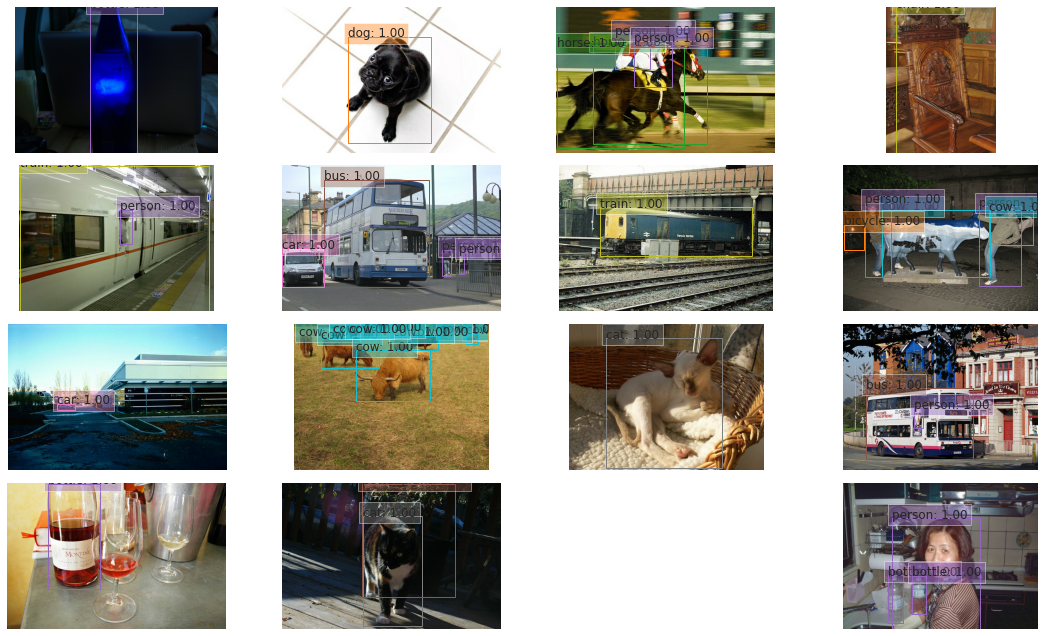

In [12]:
#@title

CLASSES = [int2str(i) for i in range(20)]
print('Classes available:', *CLASSES, sep='\n  - ')
print('Examples:')

plt.figure(figsize=(16, 9))

for ix, i in enumerate(train.take(16)):
    image = i['image']
    boxes = i['objects']['bbox']

    # bbox: ymin / height, xmin / width, ymax / height, xmax / width
    h, w, _ = i['image'].shape

    boxes = swap_xy(boxes * tf.constant([[h, w, h, w]], tf.float32))
    classes = [int2str(e) for e in i['objects']['label']]
    colors = [C[e % len(C)] for e in i['objects']['label']]

    plt.subplot(4, 4, ix + 1)
    visualize_detections(image, boxes, classes, tf.ones(len(boxes)), colors)
    plt.tight_layout();

### Preprocessing Functions

In [13]:
# preprocessing functions

def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1)
    return image, boxes


def resize_and_pad_image(image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0):
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])  # -> (xmin / width, ymin / height, xmax / width, ymax / height)
    class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

### Preparing

In [14]:
label_encoder = LabelEncoder()

autotune = tf.data.experimental.AUTOTUNE

train_dataset = train.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(Config.data.buffer_size)
train_dataset = train_dataset.padded_batch(
    batch_size=Config.data.batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = valid.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=Config.data.batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

## Network

In [15]:
from tensorflow.keras.layers import Layer, Conv2D, UpSampling2D, Activation


def build_head(output_filters, bias_init):
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    
    for _ in range(4):
        head.add(Conv2D(256, 3, padding="same", kernel_initializer=kernel_init))
        head.add(Activation('relu'))

    head.add(Conv2D(output_filters, 3, 1,
                    padding="same",
                    kernel_initializer=kernel_init,
                    bias_initializer=bias_init))
    return head

class FeaturePyramid(Layer):
    def __init__(self, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.conv_c3_1x1 = Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = Conv2D(256, 3, 2, "same")
        self.upsample_2x = UpSampling2D(2)

    def call(self, inputs):
        c3_output, c4_output, c5_output = inputs
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [16]:
#@title Decode Predictions Layer

class DecodePredictions(Layer):
    def __init__(
        self,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [17]:
backbone = backbone_arch(include_top=False, input_shape=[None, None, 3])
backbone = tf.keras.Model(inputs=[backbone.inputs],
                          outputs=[backbone.get_layer(l).output for l in Config.model.backbone_layers],
                          name='backbone')

94773248/94765736 [==============================] - 1s 0us/step


In [18]:
class RetinaLayer(Layer):
    def __init__(self, num_classes, **kwargs):
        super().__init__(name='RetinaLayer', **kwargs)
        
        self.num_classes = num_classes
        self.cls_head = build_head(9 * num_classes, tf.constant_initializer(-np.log((1 - 0.01) / 0.01)))
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, features):
        fs = tf.shape(features[0])
        N = fs[0]
        
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(tf.reshape(self.cls_head(feature), [N, -1, self.num_classes]))
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

def build_retinanet(backbone, num_classes):
    inputs = backbone.inputs
    features = backbone.outputs
    features = FeaturePyramid()(features)
    predictions = RetinaLayer(num_classes)(features)

    return tf.keras.Model(inputs=inputs,
                          outputs=predictions,
                          name='retinanet')

retinanet = build_retinanet(backbone, len(CLASSES))

## Training

### Loss Functions and Metrics

In [19]:
class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self.delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(tf.less(absolute_difference, self.delta),
                        0.5 * squared_difference,
                        absolute_difference - 0.5)
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self.alpha, (1.0 - self.alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self.gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )

        cls_predictions = y_pred[:, :, 4:]
        
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        
        return clf_loss + box_loss

### Learning Rate Behavior over Time

In [20]:
train_samples = info.splits['train'].num_examples
train_steps = train_samples / Config.data.batch_size

In [21]:
train_steps * 18

51453.0

In [22]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000]
LR = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

# LR = (CosineDecayRestarts(Config.training.lr_initial,
#                           Config.training.lr_first_decay_steps,
#                           t_mul=1., m_mul=.7, alpha=0.1)
#       if Config.training.lr_first_decay_steps
#       else Config.training.lr_initial)

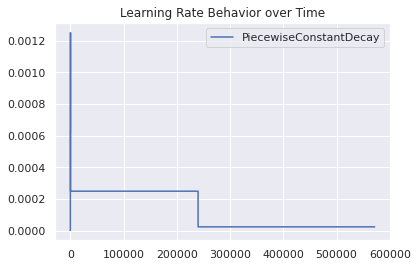

In [23]:
#@title

def plot_lr_over_time():
    steps_per_epoch = info.splits["train"].num_examples // Config.data.batch_size

    steps = np.asarray([0] + learning_rate_boundaries + [Config.training.epochs * steps_per_epoch])
    steps = np.sort(np.concatenate((steps, steps + 1)))
    lr_over_time = tf.stack([LR(i) for i in steps])

    sns.lineplot(x=steps, y=lr_over_time, label='PiecewiseConstantDecay')
    # sns.lineplot(x=steps,
    #              y=LR(steps) if Config.training.lr_first_decay_steps else [Config.training.lr_initial] * Config.training.epochs,
    #              label='SGDRDecay' if Config.training.lr_first_decay_steps else 'constant')
    plt.title('Learning Rate Behavior over Time');

plot_lr_over_time()

In [24]:
retinanet.compile(
    loss=RetinaNetLoss(num_classes=len(CLASSES)),
    optimizer=tf.optimizers.SGD(learning_rate=LR, momentum=0.9))

In [ ]:
if Config.training.do:
    retinanet.load_weights(Config.logs.path + '/weights.h5')

    try:
        retinanet.fit(
            train_dataset,
            initial_epoch=18,
            epochs=Config.training.epochs,
            validation_data=val_dataset,
            callbacks=[
                tf.keras.callbacks.TerminateOnNaN(),
                tf.keras.callbacks.EarlyStopping(
                    patience=Config.training.early_stopping_patience,
                    verbose=1),
                tf.keras.callbacks.TensorBoard(
                    log_dir=Config.logs.path,
                    histogram_freq=max(1, Config.training.epochs // 10),
                    write_graph=False),
                tf.keras.callbacks.ModelCheckpoint(
                    Config.logs.path + '/weights.h5',
                    save_weights_only=True,
                    save_best_only=True,
                    verbose=1),
                tf.keras.callbacks.ReduceLROnPlateau(
                    patience=Config.training.reduce_lr_on_plateau_patience,
                    factor=Config.training.reduce_lr_on_plateau_factor,
                    verbose=1),
            ])

    except KeyboardInterrupt: print('\ninterrupted')
    else: print('done')

Epoch 19/200
 534/2858 [====>.........................] - ETA: 49:20 - loss: 0.6629

## Evaluation and Examples

In [24]:
retinanet.load_weights(Config.logs.path + '/weights.h5')

In [25]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = retinanet(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
retinanet_inference = tf.keras.Model(inputs=image, outputs=detections)

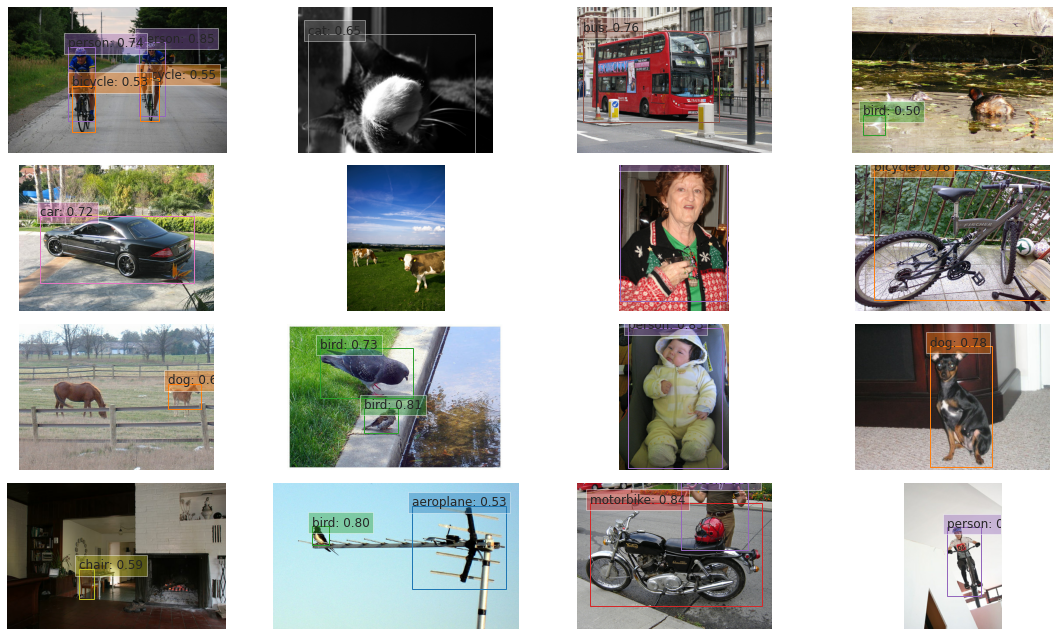

In [26]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
    image = preprocessing_fn(image)
    return tf.expand_dims(image, axis=0), ratio

plt.figure(figsize=(16, 9))

for ix, sample in enumerate(valid.take(16)):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = retinanet_inference.predict(input_image)
    num_detections = detections.valid_detections[0]

    labels = [int(x) for x in detections.nmsed_classes[0][:num_detections]]
    class_names = [int2str(int(x)) for x in labels]
    colors = [C[x % len(C)] for x in labels]

    plt.subplot(4, 4, ix + 1)
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
        colors
    )
plt.tight_layout()